In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from gensim.corpora import Dictionary
from gensim.models import  LsiModel, LdaModel, TfidfModel

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:06, 3044.41it/s]


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


#  –î–æ–º–∞—à–Ω–µ–µ –∑–∞–¥–∞–Ω–∏–µ –ø–æ NLP # 1 [100 –±–∞–ª–ª–æ–≤]
## –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ 

–í —ç—Ç–æ–º –¥–æ–º–∞—à–Ω–µ–º –∑–∞–¥–∞–Ω–∏–∏ –≤–∞–º –ø—Ä–µ–¥—Å—Ç–æ–∏—Ç –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ –æ—Ç–∑—ã–≤—ã –Ω–∞ –±–∞–Ω–∫–∏ —Å —Å–∞–π—Ç–∞ banki.ru.

–î–∞–Ω–Ω—ã–µ —Å–æ–¥–µ—Ä–∂–∞—Ç –Ω–µ–ø–æ—Å—Ä–µ–¥—Å—Ç–≤–µ–Ω–Ω–æ —Ç–µ–∫—Å—Ç—ã –æ—Ç–∑—ã–≤–æ–≤, –Ω–µ–∫–æ—Ç–æ—Ä—É—é –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é, –∞ —Ç–∞–∫–∂–µ –æ—Ü–µ–Ω–∫—É –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5. 

–¢–µ–∫—Å—Ç—ã —Ö—Ä–∞–Ω—è—Ç—Å—è –≤ json-–∞—Ö –≤ –º–∞—Å—Å–∏–≤–µ responses.

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø—Ä–∏–º–µ—Ä –æ—Ç–∑—ã–≤–∞:

In [5]:
responses[99]

{'city': '–≥. –°–∞—Ä–∞—Ç–æ–≤',
 'rating_not_checked': False,
 'title': '–ö–∞—Ä—Ç–∞ –∫–æ –≤–∫–ª–∞–¥—É',
 'num_comments': 0,
 'bank_license': '–ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 880',
 'author': 'ronnichka',
 'bank_name': '–Æ–≥—Ä–∞',
 'datetime': '2015-06-03 20:56:57',
 'text': '–ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –•–æ—Ç–µ–ª–∞ –Ω–∞–ø–∏—Å–∞—Ç—å, —á—Ç–æ –º–Ω–µ –º–µ—Å—è—Ü –Ω–µ –≤—ã–¥–∞—é—Ç –∫–∞—Ä—Ç—É –∫–æ –≤–∫–ª–∞–¥—É, —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ "–Ω–∞–º –∂–µ –∏—Ö –∏–∑ –°–∞–º–∞—Ä—ã –≤–µ–∑—É—Ç" (–Ω–∞ —Å–µ–∫—É–Ω–¥–æ—á–∫—É 5 —á–∞—Å–æ–≤ –µ–∑–¥—ã –æ—Ç –Ω–∞—à–µ–≥–æ –≥–æ—Ä–æ–¥–∞). –ù–æ! –ü—Ä–æ—á–∏—Ç–∞–ª–∞, —á—Ç–æ –ª—é–¥—è–º 3,5 –º–µ—Å—è—Ü–µ–≤ –Ω–µ –≤—ã–¥–∞—é—Ç –∫–∞—Ä—Ç—É, –∏ –ø–æ–Ω—è–ª–∞, —á—Ç–æ —É –º–µ–Ω—è –≤—Å–µ —Ö–æ—Ä–æ—à–æ, –ø–æ–∫–∞ —á—Ç–æ. –ò –ø–æ–¥–∞—Ä–æ–∫ –º–Ω–µ –¥–∞–ª–∏, –∏ –∫—É–ª–µ—Ä –≤ –æ—Ç–¥–µ–ª–µ–Ω–∏–∏ –µ—Å—Ç—å. –¢–∞–∫ —á—Ç–æ —è, –∫–æ–Ω–µ—á–Ω–æ, –≥–æ—Ç–æ–≤–∞ –∂–¥–∞—Ç—å. –ü—Ä–∞–≤–¥–∞ —Ö–æ—Ç–µ–ª–æ—Å—å –±—ã –Ω–µ –æ—á–µ–Ω—å –¥–æ–ª–≥–æ.',
 'rating_grade': 3}

## –ß–∞—Å—Ç—å 1. –ê–Ω–∞–ª–∏–∑ —Ç–µ–∫—Å—Ç–æ–≤ [40/100]

1. –ü–æ—Å—á–∏—Ç–∞–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤ –≤ —Ä–∞–∑–Ω—ã—Ö –≥–æ—Ä–æ–¥–∞—Ö –∏ –Ω–∞ —Ä–∞–∑–Ω—ã–µ –±–∞–Ω–∫–∏
2. –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –≥–∏—Å—Ç–æ–≥—Ä–∞–º—ã –¥–ª–∏–Ω —Å–ª–æ–≤ –≤ —Å–∏–º–≤–æ–ª–∞—Ö –∏ –≤ —Å–ª–æ–≤–∞—Ö
3. –ù–∞–π–¥–∏—Ç–µ 10 —Å–∞–º—ã—Ö —á–∞—Å—Ç—ã—Ö:
    * —Å–ª–æ–≤
    * —Å–ª–æ–≤ –±–µ–∑ —Å—Ç–æ–ø-—Å–ª–æ–≤
    * –ª–µ–º–º 
* —Å—É—â–µ—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã—Ö
4. –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –∫—Ä–∏–≤—ã–µ –¶–∏–ø—Ñ–∞ –∏ –•–∏–ø—Å–∞
5. –û—Ç–≤–µ—Ç—å—Ç–µ –Ω–∞ —Å–ª–µ–¥—É—é—â–∏–µ –≤–æ–ø—Ä–æ—Å—ã:
    * –∫–∞–∫–æ–µ —Å–ª–æ–≤–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ, "—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" –∏–ª–∏ "–∫–ª–∏–µ–Ω—Ç"?
    * —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —Å–ª–æ–≤–∞ "–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ" –∏ "–¥–æ–≤–µ—Ä–∏–µ"?
6. –í –ø–æ–ª–µ "rating_grade" –∑–∞–ø–∏—Å–∞–Ω–∞ –æ—Ü–µ–Ω–∫–∞ –æ—Ç–∑—ã–≤–∞ –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –º–µ—Ä—É $tf-idf$, –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –Ω–∞–π—Ç–∏ –∫–ª—é—á–µ–≤—ã–µ —Å–ª–æ–≤–∞ –∏ –±–∏–≥—Ä–∞–º—ã –¥–ª—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 5) –∏ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 1)

In [6]:
df=pd.DataFrame.from_dict(responses)

In [7]:
df.head()

city  rating_not_checked  \
0       –≥. –ú–æ—Å–∫–≤–∞               False   
1  –≥. –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫               False   
2       –≥. –ú–æ—Å–∫–≤–∞               False   
3   –≥. –°—Ç–∞–≤—Ä–æ–ø–æ–ª—å               False   
4    –≥. –ß–µ–ª—è–±–∏–Ω—Å–∫               False   

                                               title  num_comments  \
0                                             –ñ–∞–ª–æ–±–∞             0   
1      –ù–µ –º–æ–≥—É –ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è —É—Å–ª—É–≥–æ–π –°–±–µ—Ä–±–∞–Ω–∫ –æ–Ω-–ª–∞–π–Ω             0   
2                    –î–≤–æ–π–Ω–æ–µ —Å–ø–∏—Å–∞–Ω–∏–µ –∑–∞ –æ–¥–∏–Ω —Ç–æ–≤–∞—Ä.             1   
3  –ú–µ–Ω—è—é—Ç –ø—Ä–æ—Ü–µ–Ω—Ç—ã –∫–æ–º–∏—Å—Å–∏–∏  –Ω–µ –ø—Ä–µ–¥—É–ø—Ä–µ–¥–∏–≤ –∏ –Ω–µ ...             2   
4             –í–µ—Ä–Ω–∏—Ç–µ –¥–µ–Ω–µ–∂–Ω—ã–µ —Å—Ä–µ–¥—Å—Ç–≤–∞ –∑–∞ —Å—Ç—Ä–∞—Ö–æ–≤–∫—É             1   

      bank_license       author        bank_name             datetime  \
0  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2562       uhnov1          –ë–∏–Ω–±–∞–Ω–∫  2015-06-08 12:50:54   
1  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481       Foryou  –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-08 11:09:57   
2  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2562   Vladimir84          –ë–∏–Ω–±–∞–Ω–∫  2015-06-05 20:14:28   
3  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481       643609  –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 13:51:01   
4  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2766  anfisa-2003         –û–¢–ü –ë–∞–Ω–∫  2015-06-05 10:58:12   

                                                text  rating_grade  
0  –î–æ–±—Ä—ã–π –¥–µ–Ω—å! –Ø –Ω–µ —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –∏ –ø–æ—Ä...           NaN  
1  –î–æ–±—Ä–æ–≥–æ –¥–Ω—è! –Ø–≤–ª—è—é—Å—å –¥–µ—Ä–∂–∞—Ç–µ–ª–µ–º –∑–∞—Ä–ø–ª–∞—Ç–Ω–æ–π –∫–∞—Ä...           NaN  
2  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! ¬†–î—É–±–ª–∏—Ä—É—é —Å–≤–æ–µ –∑–∞—è–≤–ª–µ–Ω–∏–µ –æ—Ç 03.0...           NaN  
3  –î–æ–±—Ä—ã–π –¥–µ–Ω—å!! –Ø –æ—Ç–∫—Ä—ã–ª —Ä–∞—Å—á–µ—Ç–Ω—ã–π —Å—á–µ—Ç –≤ –°–±–µ—Ä–ë–∞...           NaN  
4  04.03.2015 –≥. –≤–∑—è–ª–∞ –∫—Ä–µ–¥–∏—Ç –≤ –≤–∞—à–µ–º –±–∞–Ω–∫–µ, –∑–∞—è–≤...           NaN

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [9]:
# –£–¥–∞–ª–∏–º,–≥–¥–µ —Ä–µ–π—Ç–∏–Ω–≥ –Ω–µ –∏–∑–≤–µ—Å—Ç–µ–Ω
df.dropna(subset=['rating_grade'], inplace = True)

In [10]:
df.shape

(88658, 10)

### 1. –ü–æ—Å—á–∏—Ç–∞–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤ –≤ —Ä–∞–∑–Ω—ã—Ö –≥–æ—Ä–æ–¥–∞—Ö –∏ –Ω–∞ —Ä–∞–∑–Ω—ã–µ –±–∞–Ω–∫–∏

In [11]:
cities=df.groupby(['city']).count()['text'].sort_values( ascending=False).head(29)
banks=df.groupby(['bank_name']).count()['text'].sort_values( ascending=False).head(29)

Text(0.5, 0, '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤')

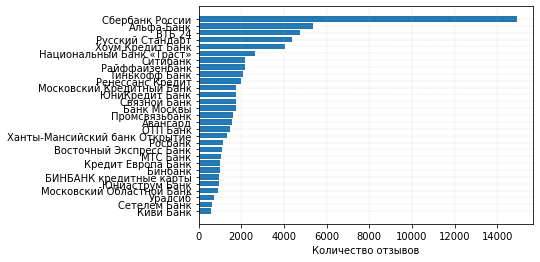

In [12]:
plt.barh(banks.index[::-1],banks.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤')

Text(0.5, 0, '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤')

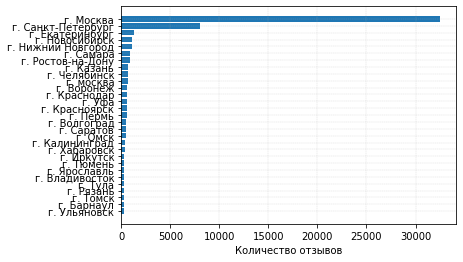

In [13]:
plt.barh(cities.index[::-1],cities.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤')

### 2. –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –≥–∏—Å—Ç–æ–≥—Ä–∞–º—ã –¥–ª–∏–Ω —Å–ª–æ–≤ –≤ —Å–∏–º–≤–æ–ª–∞—Ö –∏ –≤ —Å–ª–æ–≤–∞—Ö

In [14]:
#–¥–ª–∏–Ω–∞
len_chars = df.text.apply(len)
len_chars.describe()

count    88658.000000
mean      1718.655711
std       1387.903005
min         31.000000
25%        852.000000
50%       1345.000000
75%       2131.000000
max      32082.000000
Name: text, dtype: float64

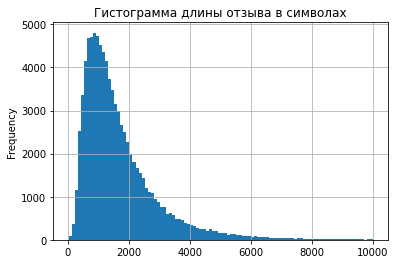

In [15]:
len_chars[len_chars<10000].plot(kind='hist',bins=100, title='–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ –¥–ª–∏–Ω—ã –æ—Ç–∑—ã–≤–∞ –≤ —Å–∏–º–≤–æ–ª–∞—Ö')

plt.grid(True)


In [16]:
len_tokens = df.text.str.split().apply(len)
len_tokens.describe()

count    88658.00000
mean       262.54814
std        213.16522
min          5.00000
25%        129.00000
50%        205.00000
75%        326.00000
max       5000.00000
Name: text, dtype: float64

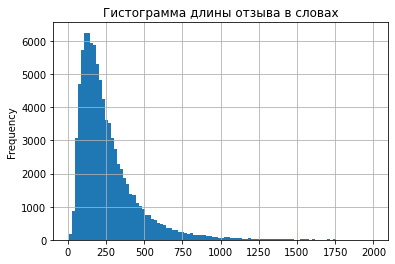

In [17]:
len_tokens[len_tokens<2000].plot(kind='hist',bins=100, title='–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ –¥–ª–∏–Ω—ã –æ—Ç–∑—ã–≤–∞ –≤ —Å–ª–æ–≤–∞—Ö')
plt.grid(True)

### –ù–∞–π–¥–∏—Ç–µ 10 —Å–∞–º—ã—Ö —á–∞—Å—Ç—ã—Ö:
    * —Å–ª–æ–≤
    * —Å–ª–æ–≤ –±–µ–∑ —Å—Ç–æ–ø-—Å–ª–æ–≤
    * –ª–µ–º–º

#### C–ª–æ–≤–∞

In [18]:
import re
regex = re.compile("[–ê-–Ø–∞-—è]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [19]:
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [20]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized'].split()
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/88658 [00:00<?, ?it/s]

('–≤', 859205)
('–∏', 683760)
('–Ω–µ', 541870)
('–Ω–∞', 453390)
('—á—Ç–æ', 417356)
('—è', 368386)
('—Å', 288214)
('–ø–æ', 232882)
('–º–Ω–µ', 209093)
('–±–∞–Ω–∫–∞', 171118)


#### C–ª–æ–≤–∞ –±–µ–∑ —Å—Ç–æ–ø-—Å–ª–æ–≤

In [21]:
from nltk.corpus import stopwords
 #print(stopwords.words('russian'))
mystopwords = stopwords.words('russian') + ['—ç—Ç–æ', '–Ω–∞—à' , '—Ç—ã—Å', '–º–ª–Ω', '–º–ª—Ä–¥', '—Ç–∞–∫–∂–µ',  '—Ç', '–¥']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return 

In [22]:
df['text_tokinized_without_stop_worlds'] =  df.text_tokinized.str.lower().apply(remove_stopwords)
df.head()

city  rating_not_checked  \
14           –≥. –ú–æ—Å–∫–≤–∞               False   
19           –≥. –ú–æ—Å–∫–≤–∞               False   
33   –≥. –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É               False   
76  –≥. –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥               False   
85           –≥. –ú–æ—Å–∫–≤–∞               False   

                                                title  num_comments  \
14                                             –í –®–æ–∫–µ             0   
19                 –ù–µ–∫–æ–º–ø–µ—Ç–µ–Ω—Ç–Ω–æ—Å—Ç—å —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤ –±–∞–Ω–∫–∞             2   
33                              –ù–∞–≤—è–∑—ã–≤–∞–Ω–∏–µ —Å—Ç—Ä–∞—Ö–æ–≤–∫–∏             1   
76              –ù–∞—Ä—É—à–µ–Ω–∏–µ –¥–æ–≥–æ–≤–æ—Ä–∞ –±–∞–Ω–∫–æ–≤—Å–∫–æ–≥–æ –≤–∫–ª–∞–¥–∞             0   
85  –ù–µ–≤–æ–∑–º–æ–∂–Ω–æ –æ–ø–ª–∞—Ç–∏—Ç—å –æ—Ç—á–∏—Å–ª–µ–Ω–∏—è –Ω–∞ –∫–∞–ø—Ä–µ–º–æ–Ω—Ç "–¢...             4   

       bank_license    author          bank_name             datetime  \
14  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2673  yura1189      –¢–∏–Ω—å–∫–æ—Ñ—Ñ –ë–∞–Ω–∫  2015-06-05 13:52:40   
19  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481    agelun    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 15:00:54   
33  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481  Joker888    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 21:35:40   
76  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 3006  qwarta45  –ê–∫—Ç–∏–≤–ö–∞–ø–∏—Ç–∞–ª –ë–∞–Ω–∫  2015-06-06 23:42:39   
85  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481       721    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-04 13:27:04   

                                                 text  rating_grade  \
14  –¢–∞–∫–∂–µ –∫–∞–∫ –∏ –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞, –±—ã–ª –¥–æ...           2.0   
19  –û—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ –∏ —Å—á–µ—Ç –≤ USD. –ü–ª—é—Å –∫ —ç—Ç–æ–º—É –µ—Å—Ç—å –∑...           1.0   
33  –î–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏! –í—á–µ—Ä–∞ –º–Ω–µ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å-—É–≤–µ–¥–æ...           1.0   
76  05.06.2015–≥. –æ–∫–æ–ª–æ 15 —á–∞—Å–æ–≤, –ø—Ä–∏—à–µ–ª –≤ —É–∫–∞–∑–∞–Ω–Ω—ã...           1.0   
85  –î–ª—è –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞...           1.0   

                                       text_tokinized  \
14  —Ç–∞–∫–∂–µ –∫–∞–∫ –∏ –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞ –±—ã–ª –¥–æ–≤...   
19  –æ—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ –∏ —Å—á–µ—Ç –≤ –ø–ª—é—Å –∫ —ç—Ç–æ–º—É –µ—Å—Ç—å –∑–∞—Ä–ø–ª–∞...   
33  –¥–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –≤—á–µ—Ä–∞ –º–Ω–µ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å —É–≤–µ–¥–æ–º...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å–æ–≤ –ø—Ä–∏—à–µ–ª –≤ —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å —Å –Ω–∞–º–µ—Ä–µ...   
85  –¥–ª—è –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞...   

                   text_tokinized_without_stop_worlds  
14  –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞ –¥–æ–≤–æ–ª–µ–Ω –≤—ã—Å—à–µ–π —Å—Ç–µ–ø...  
19  –æ—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ —Å—á–µ—Ç –ø–ª—é—Å —ç—Ç–æ–º—É –∑–∞—Ä–ø–ª–∞—Ç–Ω–∞—è –∫–∞—Ä—Ç–∞ ...  
33  –¥–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –≤—á–µ—Ä–∞ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏...  
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å–æ–≤ –ø—Ä–∏—à–µ–ª —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å –Ω–∞–º–µ—Ä–µ–Ω–∏–µ–º...  
85  –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞—Å—Ç–∏–∫...

In [23]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized_without_stop_worlds'].split()
    tokens_all+=tokens
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/88658 [00:00<?, ?it/s]

('–±–∞–Ω–∫–∞', 171118)
('–±–∞–Ω–∫', 130753)
('–¥–µ–Ω—å–≥–∏', 83171)
('–∫–∞—Ä—Ç—É', 69033)
('–∫–∞—Ä—Ç—ã', 63121)
('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 48431)
('–¥–µ–Ω—å', 48092)
('–∫—Ä–µ–¥–∏—Ç', 47746)
('–±–∞–Ω–∫–µ', 46245)
('–∑–∞—è–≤–ª–µ–Ω–∏–µ', 45279)


#### –õ–µ–º–º—ã

In [24]:
from pymorphy2 import MorphAnalyzer
# from pymystem3 import Mystem
# m = Mystem()             #–æ–æ–æ–æ—á–µ–Ω—å –¥–æ–ª–≥–æ..
pm2 = MorphAnalyzer()

def lemmatize(text, typelem=pm2):
    try:
        lemmas = [pm2.parse(word)[0].normal_form for word in text.split()]
        return ' '.join(lemmas)
    except:
        return " "

In [25]:
mystoplemmas = stopwords.words('russian') + ['–∫–æ—Ç–æ—Ä—ã–π','–ø—Ä–æ—à–ª—ã–π','—Å–µ–π', '—Å–≤–æ–π', '–Ω–∞—à', '–º–æ—á—å']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [26]:
%%time
df['lemma'] = df['text_tokinized_without_stop_worlds'].apply(lemmatize)

Wall time: 29min 55s


In [27]:
df.head()

city  rating_not_checked  \
14           –≥. –ú–æ—Å–∫–≤–∞               False   
19           –≥. –ú–æ—Å–∫–≤–∞               False   
33   –≥. –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É               False   
76  –≥. –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥               False   
85           –≥. –ú–æ—Å–∫–≤–∞               False   

                                                title  num_comments  \
14                                             –í –®–æ–∫–µ             0   
19                 –ù–µ–∫–æ–º–ø–µ—Ç–µ–Ω—Ç–Ω–æ—Å—Ç—å —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤ –±–∞–Ω–∫–∞             2   
33                              –ù–∞–≤—è–∑—ã–≤–∞–Ω–∏–µ —Å—Ç—Ä–∞—Ö–æ–≤–∫–∏             1   
76              –ù–∞—Ä—É—à–µ–Ω–∏–µ –¥–æ–≥–æ–≤–æ—Ä–∞ –±–∞–Ω–∫–æ–≤—Å–∫–æ–≥–æ –≤–∫–ª–∞–¥–∞             0   
85  –ù–µ–≤–æ–∑–º–æ–∂–Ω–æ –æ–ø–ª–∞—Ç–∏—Ç—å –æ—Ç—á–∏—Å–ª–µ–Ω–∏—è –Ω–∞ –∫–∞–ø—Ä–µ–º–æ–Ω—Ç "–¢...             4   

       bank_license    author          bank_name             datetime  \
14  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2673  yura1189      –¢–∏–Ω—å–∫–æ—Ñ—Ñ –ë–∞–Ω–∫  2015-06-05 13:52:40   
19  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481    agelun    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 15:00:54   
33  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481  Joker888    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 21:35:40   
76  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 3006  qwarta45  –ê–∫—Ç–∏–≤–ö–∞–ø–∏—Ç–∞–ª –ë–∞–Ω–∫  2015-06-06 23:42:39   
85  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481       721    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-04 13:27:04   

                                                 text  rating_grade  \
14  –¢–∞–∫–∂–µ –∫–∞–∫ –∏ –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞, –±—ã–ª –¥–æ...           2.0   
19  –û—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ –∏ —Å—á–µ—Ç –≤ USD. –ü–ª—é—Å –∫ —ç—Ç–æ–º—É –µ—Å—Ç—å –∑...           1.0   
33  –î–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏! –í—á–µ—Ä–∞ –º–Ω–µ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å-—É–≤–µ–¥–æ...           1.0   
76  05.06.2015–≥. –æ–∫–æ–ª–æ 15 —á–∞—Å–æ–≤, –ø—Ä–∏—à–µ–ª –≤ —É–∫–∞–∑–∞–Ω–Ω—ã...           1.0   
85  –î–ª—è –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞...           1.0   

                                       text_tokinized  \
14  —Ç–∞–∫–∂–µ –∫–∞–∫ –∏ –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞ –±—ã–ª –¥–æ–≤...   
19  –æ—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ –∏ —Å—á–µ—Ç –≤ –ø–ª—é—Å –∫ —ç—Ç–æ–º—É –µ—Å—Ç—å –∑–∞—Ä–ø–ª–∞...   
33  –¥–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –≤—á–µ—Ä–∞ –º–Ω–µ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å —É–≤–µ–¥–æ–º...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å–æ–≤ –ø—Ä–∏—à–µ–ª –≤ —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å —Å –Ω–∞–º–µ—Ä–µ...   
85  –¥–ª—è –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞...   

                   text_tokinized_without_stop_worlds  \
14  –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞ –¥–æ–≤–æ–ª–µ–Ω –≤—ã—Å—à–µ–π —Å—Ç–µ–ø...   
19  –æ—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ —Å—á–µ—Ç –ø–ª—é—Å —ç—Ç–æ–º—É –∑–∞—Ä–ø–ª–∞—Ç–Ω–∞—è –∫–∞—Ä—Ç–∞ ...   
33  –¥–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –≤—á–µ—Ä–∞ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å–æ–≤ –ø—Ä–∏—à–µ–ª —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å –Ω–∞–º–µ—Ä–µ–Ω–∏–µ–º...   
85  –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞—Å—Ç–∏–∫...   

                                                lemma  
14  –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ –¥–æ–≤–æ–ª—å–Ω—ã–π –≤—ã—Å–æ–∫–∏–π —Å—Ç...  
19  –æ—Ç–∫—Ä—ã—Ç—å –≤–∫–ª–∞–¥ —Å—á—ë—Ç –ø–ª—é—Å —ç—Ç–æ—Ç –∑–∞—Ä–ø–ª–∞—Ç–Ω—ã–π –∫–∞—Ä—Ç–∞ ...  
33  –¥–æ–±—Ä—ã–π –≤—Ä–µ–º—è –≤—á–µ—Ä–∞ –ø–æ—Å—Ç—É–ø–∏—Ç—å —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏–µ –±...  
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å –ø—Ä–∏–π—Ç–∏ —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å –Ω–∞–º–µ—Ä–µ–Ω–∏–µ –ø–æ...  
85  –æ–ø–ª–∞—Ç–∞ –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã–π –ø–ª–∞—Ç—ë–∂ –ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è –ø–ª–∞—Å—Ç–∏...

In [28]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    #print(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    #print(cnt.values())
    #print('__________________________')
    #print(sum(cnt.values()))
    n_tokens.append(sum(cnt.values()))
    #break
for i in cnt.most_common(10):
    print(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/88658 [00:00<?, ?it/s]

('–±–∞–Ω–∫', 413149)
('–∫–∞—Ä—Ç–∞', 211438)
('–¥–µ–Ω—å–≥–∞', 114398)
('–¥–µ–Ω—å', 112825)
('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 105610)
('–º–æ–π', 98205)
('–∫–æ—Ç–æ—Ä—ã–π', 94335)
('–∫—Ä–µ–¥–∏—Ç', 91324)
('—Å–æ—Ç—Ä—É–¥–Ω–∏–∫', 88252)
('–∫–ª–∏–µ–Ω—Ç', 88018)


### –°—É—â–µ—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã–µ

In [29]:
def to_nouns(text, typelem=pm2):
    try:
        return  " ".join([noun for noun in text.split() if typelem.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return ""

In [30]:
%%time
df['NOUN'] = df['lemma'].apply(to_nouns)
df.head()

Wall time: 29min 4s


city  rating_not_checked  \
14           –≥. –ú–æ—Å–∫–≤–∞               False   
19           –≥. –ú–æ—Å–∫–≤–∞               False   
33   –≥. –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É               False   
76  –≥. –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥               False   
85           –≥. –ú–æ—Å–∫–≤–∞               False   

                                                title  num_comments  \
14                                             –í –®–æ–∫–µ             0   
19                 –ù–µ–∫–æ–º–ø–µ—Ç–µ–Ω—Ç–Ω–æ—Å—Ç—å —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤ –±–∞–Ω–∫–∞             2   
33                              –ù–∞–≤—è–∑—ã–≤–∞–Ω–∏–µ —Å—Ç—Ä–∞—Ö–æ–≤–∫–∏             1   
76              –ù–∞—Ä—É—à–µ–Ω–∏–µ –¥–æ–≥–æ–≤–æ—Ä–∞ –±–∞–Ω–∫–æ–≤—Å–∫–æ–≥–æ –≤–∫–ª–∞–¥–∞             0   
85  –ù–µ–≤–æ–∑–º–æ–∂–Ω–æ –æ–ø–ª–∞—Ç–∏—Ç—å –æ—Ç—á–∏—Å–ª–µ–Ω–∏—è –Ω–∞ –∫–∞–ø—Ä–µ–º–æ–Ω—Ç "–¢...             4   

       bank_license    author          bank_name             datetime  \
14  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2673  yura1189      –¢–∏–Ω—å–∫–æ—Ñ—Ñ –ë–∞–Ω–∫  2015-06-05 13:52:40   
19  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481    agelun    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 15:00:54   
33  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481  Joker888    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 21:35:40   
76  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 3006  qwarta45  –ê–∫—Ç–∏–≤–ö–∞–ø–∏—Ç–∞–ª –ë–∞–Ω–∫  2015-06-06 23:42:39   
85  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481       721    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-04 13:27:04   

                                                 text  rating_grade  \
14  –¢–∞–∫–∂–µ –∫–∞–∫ –∏ –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞, –±—ã–ª –¥–æ...           2.0   
19  –û—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ –∏ —Å—á–µ—Ç –≤ USD. –ü–ª—é—Å –∫ —ç—Ç–æ–º—É –µ—Å—Ç—å –∑...           1.0   
33  –î–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏! –í—á–µ—Ä–∞ –º–Ω–µ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å-—É–≤–µ–¥–æ...           1.0   
76  05.06.2015–≥. –æ–∫–æ–ª–æ 15 —á–∞—Å–æ–≤, –ø—Ä–∏—à–µ–ª –≤ —É–∫–∞–∑–∞–Ω–Ω—ã...           1.0   
85  –î–ª—è –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞...           1.0   

                                       text_tokinized  \
14  —Ç–∞–∫–∂–µ –∫–∞–∫ –∏ –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞ –±—ã–ª –¥–æ–≤...   
19  –æ—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ –∏ —Å—á–µ—Ç –≤ –ø–ª—é—Å –∫ —ç—Ç–æ–º—É –µ—Å—Ç—å –∑–∞—Ä–ø–ª–∞...   
33  –¥–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –≤—á–µ—Ä–∞ –º–Ω–µ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å —É–≤–µ–¥–æ–º...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å–æ–≤ –ø—Ä–∏—à–µ–ª –≤ —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å —Å –Ω–∞–º–µ—Ä–µ...   
85  –¥–ª—è –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞...   

                   text_tokinized_without_stop_worlds  \
14  –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞ –¥–æ–≤–æ–ª–µ–Ω –≤—ã—Å—à–µ–π —Å—Ç–µ–ø...   
19  –æ—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ —Å—á–µ—Ç –ø–ª—é—Å —ç—Ç–æ–º—É –∑–∞—Ä–ø–ª–∞—Ç–Ω–∞—è –∫–∞—Ä—Ç–∞ ...   
33  –¥–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –≤—á–µ—Ä–∞ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å–æ–≤ –ø—Ä–∏—à–µ–ª —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å –Ω–∞–º–µ—Ä–µ–Ω–∏–µ–º...   
85  –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞—Å—Ç–∏–∫...   

                                                lemma  \
14  –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ –¥–æ–≤–æ–ª—å–Ω—ã–π –≤—ã—Å–æ–∫–∏–π —Å—Ç...   
19  –æ—Ç–∫—Ä—ã—Ç—å –≤–∫–ª–∞–¥ —Å—á—ë—Ç –ø–ª—é—Å —ç—Ç–æ—Ç –∑–∞—Ä–ø–ª–∞—Ç–Ω—ã–π –∫–∞—Ä—Ç–∞ ...   
33  –¥–æ–±—Ä—ã–π –≤—Ä–µ–º—è –≤—á–µ—Ä–∞ –ø–æ—Å—Ç—É–ø–∏—Ç—å —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏–µ –±...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å –ø—Ä–∏–π—Ç–∏ —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å –Ω–∞–º–µ—Ä–µ–Ω–∏–µ –ø–æ...   
85  –æ–ø–ª–∞—Ç–∞ –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã–π –ø–ª–∞—Ç—ë–∂ –ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è –ø–ª–∞—Å—Ç–∏...   

                                                 NOUN  
14  –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ —Å—Ç–µ–ø–µ–Ω—å –¥—Ä—É–≥ –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫...  
19  –≤–∫–ª–∞–¥ —Å—á—ë—Ç –∫–∞—Ä—Ç–∞ —Ä—É–±–ª—å –æ—Ç–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–ª—å –æ–ø–µ—Ä–∞—Ü–∏–æ...  
33  –≤—Ä–µ–º—è —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏–µ –±–∞–Ω–∫ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –∫—Ä–µ–¥–∏—Ç ...  
76 

In [31]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun= []
tokens_noun = []
tokens_all_noun=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['NOUN'].split()
    #print(tokens)
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    #print(cnt.values())
    #print('__________________________')
    #print(sum(cnt.values()))
    n_tokens_noun.append(sum(cnt.values()))
    #break
for i in cnt_noun.most_common(10):
    print(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/88658 [00:00<?, ?it/s]

('–±–∞–Ω–∫', 413149)
('–∫–∞—Ä—Ç–∞', 211438)
('–¥–µ–Ω—å–≥–∞', 114398)
('–¥–µ–Ω—å', 112825)
('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 105610)
('–∫—Ä–µ–¥–∏—Ç', 91324)
('—Å–æ—Ç—Ä—É–¥–Ω–∏–∫', 88252)
('–∫–ª–∏–µ–Ω—Ç', 88018)
('—Å—á—ë—Ç', 81909)
('–∑–∞—è–≤–ª–µ–Ω–∏–µ', 66721)


#### 4. –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –∫—Ä–∏–≤—ã–µ –¶–∏–ø—Ñ–∞ –∏ –•–∏–ø—Å–∞

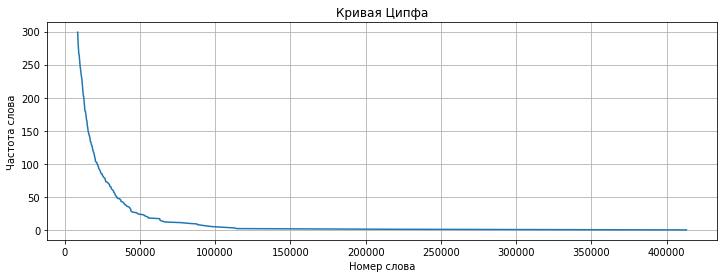

In [32]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('–ù–æ–º–µ—Ä —Å–ª–æ–≤–∞')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞ —Å–ª–æ–≤–∞')
plt.title('–ö—Ä–∏–≤–∞—è –¶–∏–ø—Ñ–∞')
plt.grid()

plt.show()

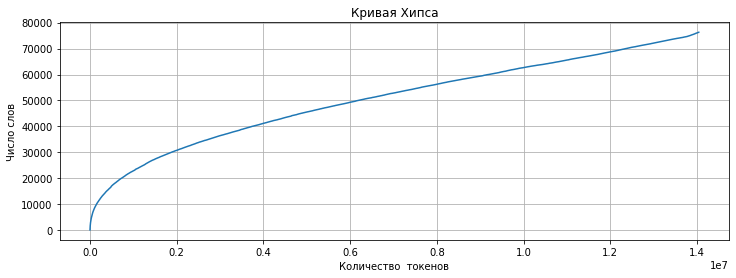

In [33]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(n_tokens,n_types)
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ  —Ç–æ–∫–µ–Ω–æ–≤')
plt.ylabel('–ß–∏—Å–ª–æ —Å–ª–æ–≤')
plt.title('–ö—Ä–∏–≤–∞—è –•–∏–ø—Å–∞')
plt.grid()

plt.show()

5. –û—Ç–≤–µ—Ç—å—Ç–µ –Ω–∞ —Å–ª–µ–¥—É—é—â–∏–µ –≤–æ–ø—Ä–æ—Å—ã:
    * –∫–∞–∫–æ–µ —Å–ª–æ–≤–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ, "—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" –∏–ª–∏ "–∫–ª–∏–µ–Ω—Ç"?
    * —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —Å–ª–æ–≤–∞ "–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ" –∏ "–¥–æ–≤–µ—Ä–∏–µ"?

In [34]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all)

In [35]:
print('"—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" –≤—Å—Ç—Ä—á–∞–µ—Ç—Å—è: ',Freq_Dist['—Å–æ—Ç—Ä—É–¥–Ω–∏–∫'],'—Ä–∞–∑')
print('"–∫–ª–∏–µ–Ω—Ç" –≤—Å—Ç—Ä—á–∞–µ—Ç—Å—è: ',Freq_Dist['–∫–ª–∏–µ–Ω—Ç'],'—Ä–∞–∑')

if Freq_Dist['—Å–æ—Ç—Ä—É–¥–Ω–∏–∫'] > Freq_Dist['–∫–ª–∏–µ–Ω—Ç']:
    print('"–°–æ—Ç—Ä—É–¥–Ω–∏–∫" –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ')
else:
    print('"–ö–ª–∏–µ–Ω—Ç" –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ')

"—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" –≤—Å—Ç—Ä—á–∞–µ—Ç—Å—è:  88252 —Ä–∞–∑
"–∫–ª–∏–µ–Ω—Ç" –≤—Å—Ç—Ä—á–∞–µ—Ç—Å—è:  88018 —Ä–∞–∑
"–°–æ—Ç—Ä—É–¥–Ω–∏–∫" –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ


In [36]:
print('"–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ" –≤—Å—Ç—Ä—á–∞–µ—Ç—Å—è: "',Freq_Dist['–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ'],'—Ä–∞–∑')
print('"–¥–æ–≤–µ—Ä–∏–µ" –≤—Å—Ç—Ä—á–∞–µ—Ç—Å—è: "',Freq_Dist['–¥–æ–≤–µ—Ä–∏–µ'],'—Ä–∞–∑')

"–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ" –≤—Å—Ç—Ä—á–∞–µ—Ç—Å—è: " 1299 —Ä–∞–∑
"–¥–æ–≤–µ—Ä–∏–µ" –≤—Å—Ç—Ä—á–∞–µ—Ç—Å—è: " 1259 —Ä–∞–∑


#### 6. –í –ø–æ–ª–µ "rating_grade" –∑–∞–ø–∏—Å–∞–Ω–∞ –æ—Ü–µ–Ω–∫–∞ –æ—Ç–∑—ã–≤–∞ –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –º–µ—Ä—É $tf-idf$, –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –Ω–∞–π—Ç–∏ –∫–ª—é—á–µ–≤—ã–µ —Å–ª–æ–≤–∞ –∏ –±–∏–≥—Ä–∞–º—ã –¥–ª—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 5) –∏ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 1)

In [37]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [38]:
#–° –≤–∏–¥—É —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –≤—ã–±–æ—Ä–∫–∞. –í—ã–±–µ—Ä–µ–º –ø–æ 7 —Ç—ã—Å—è—á –ø—Ä–∏–º–µ—Ä–æ–≤

In [39]:
num=7000
df_for_tf_idf = df[(df.rating_grade==1)].sample(n=num).copy()
df_for_tf_idf=df_for_tf_idf.append(df[(df.rating_grade==5)].sample(n=num))

In [40]:
df_for_tf_idf.rating_grade.value_counts()

5.0    7000
1.0    7000
Name: rating_grade, dtype: int64

In [41]:
tokens_by_topic = []

In [42]:
for rating in df_for_tf_idf.rating_grade.unique():
    print(rating)
    #if df['topic'].value_counts()[topic] > 100: 
    tokens=[]
    sample=df_for_tf_idf[df_for_tf_idf['rating_grade']==rating]
    for i in range(len(sample)):
        tokens += sample.lemma.iloc[i].split()
    tokens_by_topic.append(tokens)

1.0
5.0


#### –£–Ω–∏–≥—Ä–∞–º–º—ã

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase)    

#### –ù–∞ —É—Ä–æ–≤–Ω–µ —é–Ω–∏–≥—Ä–∞–º–º , –∫—Å—Ç–∞—Ç–∏, –º–Ω–æ–≥–æ–µ –ø–µ—Ä–µ—Å–µ–∫–∞–µ—Ç—Å—è. –í–∏–¥–Ω—ã –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏

In [44]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(15)

tfidf_ranking_rank_is_5 tfidf_ranking_rank_is_1
0                     –±–∞–Ω–∫                    –±–∞–Ω–∫
1                    –∫–∞—Ä—Ç–∞                   –∫–∞—Ä—Ç–∞
2                    –æ—á–µ–Ω—å                  –¥–µ–Ω—å–≥–∞
3                   –∫—Ä–µ–¥–∏—Ç                    –¥–µ–Ω—å
4                     –¥–µ–Ω—å                     –º–æ–π
5                   –∫–ª–∏–µ–Ω—Ç               –æ—Ç–¥–µ–ª–µ–Ω–∏–µ
6                –æ—Ç–¥–µ–ª–µ–Ω–∏–µ                 –∫–æ—Ç–æ—Ä—ã–π
7                  –∫–æ—Ç–æ—Ä—ã–π                  –∫—Ä–µ–¥–∏—Ç
8                   –¥–µ–Ω—å–≥–∞               —Å–æ—Ç—Ä—É–¥–Ω–∏–∫
9                —Å–æ—Ç—Ä—É–¥–Ω–∏–∫                    —Å—á—ë—Ç
10                   –≤–∫–ª–∞–¥                 —Å–∫–∞–∑–∞—Ç—å
11                     –º–æ–π                  –∫–ª–∏–µ–Ω—Ç
12                     –≥–æ–¥               –∑–∞—è–≤–ª–µ–Ω–∏–µ
13                   –≤—Ä–µ–º—è                   —Å—É–º–º–∞
14                  –≤–æ–ø—Ä–æ—Å                    —Å–≤–æ–π

In [45]:
rankings.shape

(70, 2)

#### –ü–æ–ø—Ä–æ–±—É–µ–º –∏—Å–∫–ª—é—á–∏—Ç—å –ø—Ä–µ—Å–µ–∫–∞—é—â—â–∏–µ–π—Å—è –ª–µ–º–º—ã –∏–∑ —Ç–æ–ø–æ–≤

In [46]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]

In [47]:
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [48]:
#–í–æ—Ç —Ç–∞–∫ –±–æ–ª—å—à–µ —Ä–∞–∑–Ω–∏—Ü—É –≤–∏–¥–Ω–æ
rankings.iloc[:,-2:].dropna()

tfidf_ranking_rank_is_5_without_1 tfidf_ranking_rank_is_1_without_5
19                      –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ                             –æ—Ç–≤–µ—Ç
30                          –∏–Ω—Ç–µ—Ä–Ω–µ—Ç                          –Ω–∞–ø–∏—Å–∞—Ç—å
35                            –º–∏–Ω—É—Ç–∞                               –≤–∞—à
38                              –≤–µ—Å—å                          –≥–æ–≤–æ—Ä–∏—Ç—å
45                           —Ö–æ—Ä–æ—à–∏–π                           –¥–æ–ª–∂–Ω—ã–π
46                            –ø–µ—Ä–≤—ã–π                            –ø–æ—á–µ–º—É
49                           –ø—Ä–æ—Ü–µ–Ω—Ç                          —Å–∏—Ç—É–∞—Ü–∏—è
54                         –Ω–µ—Å–∫–æ–ª—å–∫–æ                        –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è

#### –ü—Ä–æ–¥–µ–ª–∞–µ–º —Ç–∞–∫–æ–µ –∂–µ —É–ø—Ä–∞–∂–Ω–µ–Ω–∏–∏ –¥–ª—è –±–∏–≥—Ä–∞–º–º

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase) 

In [50]:
# –¢–æ–∂–µ —Å–∞–º–æ–µ.–ü—Ä–æ–¥–µ–ª–∞–µ–º —Ç–æ—Ç –∂–µ —Ç—Ä—é–∫
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(15)

tfidf_ranking_rank_is_5 tfidf_ranking_rank_is_1
0            –∏–Ω—Ç–µ—Ä–Ω–µ—Ç –±–∞–Ω–∫          —Å–æ—Ç—Ä—É–¥–Ω–∏–∫ –±–∞–Ω–∫
1          –∫—Ä–µ–¥–∏—Ç–Ω—ã–π –∫–∞—Ä—Ç–∞         –∫—Ä–µ–¥–∏—Ç–Ω—ã–π –∫–∞—Ä—Ç–∞
2              –¥—Ä—É–≥–æ–π –±–∞–Ω–∫          –æ—Ç–¥–µ–ª–µ–Ω–∏–µ –±–∞–Ω–∫
3           —Å–æ—Ç—Ä—É–¥–Ω–∏–∫ –±–∞–Ω–∫       –¥–µ–Ω–µ–∂–Ω—ã–π —Å—Ä–µ–¥—Å—Ç–≤–æ
4              –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫      –Ω–∞–ø–∏—Å–∞—Ç—å –∑–∞—è–≤–ª–µ–Ω–∏–µ
5           —Å–ª–µ–¥—É—é—â–∏–π –¥–µ–Ω—å           –≥–æ—Ä—è—á–∏–π –ª–∏–Ω–∏—è
6           –æ—Ç–¥–µ–ª–µ–Ω–∏–µ –±–∞–Ω–∫                –≤–∞—à –±–∞–Ω–∫
7          —è–≤–ª—è—Ç—å—Å—è –∫–ª–∏–µ–Ω—Ç            —Ä–∞–±–æ—á–∏–π –¥–µ–Ω—å
8             –±–∞–Ω–∫ –∫–æ—Ç–æ—Ä—ã–π              –∫–æ–ª–ª —Ü–µ–Ω—Ç—Ä
9          –¥–µ–±–µ—Ç–æ–≤—ã–π –∫–∞—Ä—Ç–∞              –∞–ª—å—Ñ–∞ –±–∞–Ω–∫
10             –¥–æ–±—Ä—ã–π –¥–µ–Ω—å             –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫
11              –∞–ª—å—Ñ–∞ –±–∞–Ω–∫          —Å–ª–µ–¥—É—é—â–∏–π –¥–µ–Ω—å
12            –æ—á–µ–Ω—å —É–¥–æ–±–Ω–æ                —Å–µ–π –ø–æ—Ä–∞
13       –ø—Ä–æ—Ü–µ–Ω—Ç–Ω—ã–π —Å—Ç–∞–≤–∫–∞        —Å–ª—É–∂–±–∞ –ø–æ–¥–¥–µ—Ä–∂–∫–∞
14         –æ—á–µ–Ω—å –¥–æ–≤–æ–ª—å–Ω—ã–π             –¥–æ–±—Ä—ã–π –¥–µ–Ω—å

In [51]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]

In [52]:
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [53]:
#–ì–æ—Ä–∞–∑–¥–æ –ª—É—á—à–µ –ø–æ–ª—É—á–∏–ª–æ—Å—å
rankings.iloc[:,-2:].dropna()

tfidf_ranking_rank_is_5_without_1 tfidf_ranking_rank_is_1_without_5
12                      –æ—á–µ–Ω—å —É–¥–æ–±–Ω–æ                          —Å–µ–π –ø–æ—Ä–∞
20                   —Ö–æ—Ç–µ—Ç—å –≤—ã—Ä–∞–∑–∏—Ç—å                      —Ç–µ—á–µ–Ω–∏–µ –¥–µ–Ω—å
21                       —Ä–∞–±–æ—Ç–∞ –±–∞–Ω–∫                 –∫—Ä–µ–¥–∏—Ç–Ω—ã–π –¥–æ–≥–æ–≤–æ—Ä
24                      –æ—á–µ–Ω—å –±—ã—Å—Ç—Ä–æ                        –º–æ–π –¥–µ–Ω—å–≥–∞
26                        –º–æ–π –≤–æ–ø—Ä–æ—Å                –æ—Ç–¥–µ–ª–µ–Ω–∏–µ —Å–±–µ—Ä–±–∞–Ω–∫
27               –ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è —É—Å–ª—É–≥–∞                         –º–æ–π –∫–∞—Ä—Ç–∞
29             –∫–∞—á–µ—Å—Ç–≤–æ –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ                    –ø–æ–ª—É—á–∏—Ç—å –æ—Ç–≤–µ—Ç
32                          –±–∞–Ω–∫ –≥–æ–¥                     –º–æ–π –∑–∞—è–≤–ª–µ–Ω–∏–µ
33                  –æ–≥—Ä–æ–º–Ω—ã–π —Å–ø–∞—Å–∏–±–æ                  –ø–æ–≥–∞—à–µ–Ω–∏–µ –∫—Ä–µ–¥–∏—Ç
35                   –±–æ–ª—å—à–æ–π —Å–ø–∞—Å–∏–±–æ              –æ–±—Ä–∞—Ç–∏—Ç—å—Å—è –æ—Ç–¥–µ–ª–µ–Ω–∏–µ
37            –≤—ã—Ä–∞–∑–∏—Ç—å –±–ª–∞–≥–æ–¥–∞—Ä–Ω–æ—Å—Ç—å                       —Å–≤–æ–π –¥–µ–Ω—å–≥–∞
40                         –Ω–æ–≤—ã–π –≥–æ–¥                      –±–∞–Ω–∫ —Å–∫–∞–∑–∞—Ç—å
45                      –º–æ—á—å —Å–∫–∞–∑–∞—Ç—å                 —Å—Ä–æ–∫ —Ä–∞—Å—Å–º–æ—Ç—Ä–µ–Ω–∏–µ
46                       –±–∞–Ω–∫ –∫–ª–∏–µ–Ω—Ç                      –∑–≤–æ–Ω–∏—Ç—å –±–∞–Ω–∫
47                  –∏–ø–æ—Ç–µ—á–Ω—ã–π –∫—Ä–µ–¥–∏—Ç                          –¥–æ–ø –æ—Ñ–∏—Å
50                   —Ö–æ—Ç–µ—Ç—å –æ—Ç–º–µ—Ç–∏—Ç—å                            —Å—á —Ç–æ—Ç
51                    —Ö–æ—Ç–µ—Ç—å —Å–∫–∞–∑–∞—Ç—å                        –¥–≤–∞ –Ω–µ–¥–µ–ª—è
52            –ø–æ—Ç—Ä–µ–±–∏—Ç–µ–ª—å—Å–∫–∏–π –∫—Ä–µ–¥–∏—Ç                –µ–∂–µ–º–µ—Å—è—á–Ω—ã–π –ø–ª–∞—Ç—ë–∂
55                 –æ—á–µ–Ω—å –ø–æ–Ω—Ä–∞–≤–∏—Ç—å—Å—è                  –∑–∞—Ä–ø–ª–∞—Ç–Ω—ã–π –∫–∞—Ä—Ç–∞
57                       –∫—Ä–µ–¥–∏—Ç –±–∞–Ω–∫                     –∫–∞—Ä—Ç–∞ –∫–æ—Ç–æ—Ä—ã–π
58                        –∫–∞–∫–æ–π –ª–∏–±–æ                       —Å–≤–æ–π –∫–ª–∏–µ–Ω—Ç
59                         –¥—Ä—É–≥ –±–∞–Ω–∫                   —Å–±–µ—Ä–±–∞–Ω–∫ –æ–Ω–ª–∞–π–Ω
60                          —ç—Ç–æ –±–∞–Ω–∫                    –º–æ–±–∏–ª—å–Ω—ã–π –±–∞–Ω–∫
61                    –¥–µ–Ω—å –ø–æ–∑–≤–æ–Ω–∏—Ç—å                   –º–æ–ª–æ–¥–æ–π —á–µ–ª–æ–≤–µ–∫
62                      –±—Ä–∞—Ç—å –∫—Ä–µ–¥–∏—Ç                       —Å—É–º–º–∞ —Ä—É–±–ª—å
64                           –±–∞–Ω–∫ —Ä—É                           –ø–∏–Ω –∫–æ–¥

## –ß–∞—Å—Ç—å 2. –¢–µ–º–∞—Ç–∏—á–µ—Å–∫–æ–µ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–µ [20/100]

1. –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏—Ö –º–æ–¥–µ–ª–µ–π –∫–æ–ª–ª–µ–∫—Ü–∏–∏ –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ —Å —Ä–∞–∑–Ω—ã–º —á–∏—Å–ª–æ–º —Ç–µ–º. –ü—Ä–∏–≤–µ–¥–∏—Ç–µ –ø—Ä–∏–º–µ—Ä—ã –ø–æ–Ω—è—Ç–Ω—ã—Ö (–∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∏—Ä—É–µ–º—ã—Ö) —Ç–µ–º.
2. –ù–∞–π–¥–∏—Ç–µ —Ç–µ–º—ã, –≤ –∫–æ—Ç–æ—Ä—ã—Ö —É–ø–æ–º—è–Ω—É—Ç—ã –∫–æ–Ω–∫—Ä–µ—Ç–Ω—ã–µ –±–∞–Ω–∫–∏ (–°–±–µ—Ä–±–∞–Ω–∫, –í–¢–ë, –¥—Ä—É–≥–æ–π –±–∞–Ω–∫). –ú–æ–∂–µ—Ç–µ –ª–∏ –≤—ã –∏—Ö –ø—Ä–æ–∫–æ–º–º–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å / –æ–±—ä—è—Å–Ω–∏—Ç—å?

–≠—Ç–∞ —á–∞—Å—Ç—å –∑–∞–¥–∞–Ω–∏—è –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–¥–µ–ª–∞–Ω–∞ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º gensim. 

In [54]:
from gensim.corpora import *
texts = [df.lemma.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [55]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [56]:
# 5 —Ç–µ–º
lsi_5 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

In [57]:
lsi_5.show_topics(5)

[(0,
  '0.193*"–∫–∞—Ä—Ç–∞" + 0.129*"–∫—Ä–µ–¥–∏—Ç" + 0.110*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.109*"–¥–µ–Ω—å–≥–∞" + 0.109*"–≤–∫–ª–∞–¥" + 0.105*"—Å—á—ë—Ç" + 0.104*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.098*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.091*"—Å—É–º–º–∞" + 0.090*"—Å–±–µ—Ä–±–∞–Ω–∫"'),
 (1,
  '-0.573*"–≤–∫–ª–∞–¥" + -0.170*"–æ—á–µ—Ä–µ–¥—å" + 0.165*"–∫—Ä–µ–¥–∏—Ç" + 0.141*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + -0.136*"–æ—Ç–∫—Ä—ã—Ç—å" + 0.131*"–ø–ª–∞—Ç—ë–∂" + 0.125*"–∑–∞–¥–æ–ª–∂–µ–Ω–Ω–æ—Å—Ç—å" + 0.112*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + -0.095*"–º–∏–Ω—É—Ç–∞" + -0.094*"–æ—Ñ–∏—Å"'),
 (2,
  '0.381*"–∫—Ä–µ–¥–∏—Ç" + -0.351*"–±–∞–Ω–∫–æ–º–∞—Ç" + -0.271*"–∫–∞—Ä—Ç–∞" + 0.244*"—Å—Ç—Ä–∞—Ö–æ–≤–∫–∞" + 0.170*"–¥–æ–≥–æ–≤–æ—Ä" + -0.160*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.140*"—Å—Ç—Ä–∞—Ö–æ–≤–∞–Ω–∏–µ" + -0.137*"–¥–µ–Ω—å–≥–∞" + 0.135*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + -0.128*"–æ–ø–µ—Ä–∞—Ü–∏—è"'),
 (3,
  '0.365*"–≤–∫–ª–∞–¥" + -0.247*"–∑–∞—è–≤–∫–∞" + -0.230*"–∫–∞—Ä—Ç–∞" + 0.193*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.190*"—Å—É–º–º–∞" + 0.148*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + 0.146*"–ø–ª–∞—Ç—ë–∂" + 0.144*"—Å—Ä–µ–¥—Å—Ç–≤–æ" + 0.1

In [58]:
# 10 —Ç–µ–º
lsi_10 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

In [59]:
lsi_10.show_topics(10)

[(0,
  '0.193*"–∫–∞—Ä—Ç–∞" + 0.129*"–∫—Ä–µ–¥–∏—Ç" + 0.110*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.109*"–¥–µ–Ω—å–≥–∞" + 0.108*"–≤–∫–ª–∞–¥" + 0.105*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.105*"—Å—á—ë—Ç" + 0.098*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.091*"—Å—É–º–º–∞" + 0.089*"—Å–±–µ—Ä–±–∞–Ω–∫"'),
 (1,
  '-0.587*"–≤–∫–ª–∞–¥" + -0.168*"–æ—á–µ—Ä–µ–¥—å" + 0.147*"–∫—Ä–µ–¥–∏—Ç" + 0.139*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + -0.139*"–æ—Ç–∫—Ä—ã—Ç—å" + 0.125*"–ø–ª–∞—Ç—ë–∂" + 0.120*"–∑–∞–¥–æ–ª–∂–µ–Ω–Ω–æ—Å—Ç—å" + 0.103*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + 0.099*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.096*"–ø—Ä–µ—Ç–µ–Ω–∑–∏—è"'),
 (2,
  '0.383*"–∫—Ä–µ–¥–∏—Ç" + -0.378*"–±–∞–Ω–∫–æ–º–∞—Ç" + -0.262*"–∫–∞—Ä—Ç–∞" + 0.215*"—Å—Ç—Ä–∞—Ö–æ–≤–∫–∞" + 0.166*"–¥–æ–≥–æ–≤–æ—Ä" + 0.145*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + -0.145*"–¥–µ–Ω—å–≥–∞" + -0.144*"—Å–±–µ—Ä–±–∞–Ω–∫" + -0.127*"–æ–ø–µ—Ä–∞—Ü–∏—è" + 0.127*"–¥–æ–∫—É–º–µ–Ω—Ç"'),
 (3,
  '0.336*"–≤–∫–ª–∞–¥" + -0.285*"–∫–∞—Ä—Ç–∞" + 0.236*"–±–∞–Ω–∫–æ–º–∞—Ç" + -0.234*"–∑–∞—è–≤–∫–∞" + 0.185*"—Å—É–º–º–∞" + 0.149*"–¥–µ–Ω—å–≥–∞" + 0.142*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + 0.137*"–ø–ª–∞—Ç—ë–∂" + 0

–¢–µ–º—ã
1. –ö—Ä–µ–¥–∏—Ç–Ω–∞—è –∫–∞—Ä—Ç–∞
2. –ü–æ–≥–∞–∏—Å—å –∑–∞–¥–æ–ª–∂–µ–Ω–Ω–æ—Å—Ç—å –ø–æ –∫—Ä–µ–¥—É
3. –î–æ–≥–æ–≤–æ—Ä –ø–æ–≥–∞—à–µ–Ω–∏—è
4. –ü–æ–≥–∞—à–µ–Ω–∏—è–µ —Å—Ä–µ–¥—Å—Ç–≤
5. –†–∞—Å—Å–º–æ—Ç—Ä–µ–Ω–∏–µ –∫–æ–º–∏—Å—Å–∏–∏ –ø–æ –∑–∞–¥–æ–ª–∂–µ–Ω–Ω–æ—Å—Ç–∏
...

In [60]:
# –ø–æ—Ä–æ–±—É–µ–º LDA
from gensim.models.ldamulticore import LdaMulticore

In [61]:
# 5 —Ç–µ–º
ldamodel_5 = LdaMulticore(corpus, num_topics=5, id2word = dictionary, passes=20,workers =5)
ldamodel_5.show_topics()

[(0,
  '0.033*"–±–∞–Ω–∫" + 0.023*"–¥–µ–Ω—å–≥–∞" + 0.022*"–∫–∞—Ä—Ç–∞" + 0.020*"—Å—á—ë—Ç" + 0.015*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.010*"—Å—Ä–µ–¥—Å—Ç–≤–æ" + 0.010*"–æ–ø–µ—Ä–∞—Ü–∏—è" + 0.009*"–¥–µ–Ω—å" + 0.009*"—Å—É–º–º–∞" + 0.009*"–º–æ–π"'),
 (1,
  '0.037*"–±–∞–Ω–∫" + 0.027*"–∫—Ä–µ–¥–∏—Ç" + 0.012*"—Å—É–º–º–∞" + 0.011*"–¥–æ–≥–æ–≤–æ—Ä" + 0.010*"–¥–µ–Ω—å" + 0.010*"–º–æ–π" + 0.010*"—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" + 0.009*"–ø–ª–∞—Ç—ë–∂" + 0.008*"–∫–æ—Ç–æ—Ä—ã–π" + 0.008*"–∫—Ä–µ–¥–∏—Ç–Ω—ã–π"'),
 (2,
  '0.050*"–∫–∞—Ä—Ç–∞" + 0.022*"–±–∞–Ω–∫" + 0.012*"–¥–µ–Ω—å" + 0.011*"–∑–≤–æ–Ω–∏—Ç—å" + 0.010*"—Å–∫–∞–∑–∞—Ç—å" + 0.009*"–ø–æ–∑–≤–æ–Ω–∏—Ç—å" + 0.008*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.008*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.008*"—Ç–µ–ª–µ—Ñ–æ–Ω" + 0.008*"–º–æ–π"'),
 (3,
  '0.037*"–±–∞–Ω–∫" + 0.013*"–∫–ª–∏–µ–Ω—Ç" + 0.011*"–æ—á–µ–Ω—å" + 0.007*"–∫–æ—Ç–æ—Ä—ã–π" + 0.006*"—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" + 0.006*"—Ä–∞–±–æ—Ç–∞" + 0.006*"–≤—Ä–µ–º—è" + 0.006*"–æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ" + 0.006*"—Å–≤–æ–π" + 0.006*"–≥–æ–¥"'),
 (4,
  '0.019*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.018*"

In [62]:
# 10 —Ç–µ–º
ldamodel_20 = LdaMulticore(corpus, num_topics=10, id2word = dictionary, passes=20,workers =5)
ldamodel_20.show_topics()

[(0,
  '0.056*"–¥–µ–Ω—å–≥–∞" + 0.052*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.020*"–±–∞–Ω–∫" + 0.017*"–¥–µ–Ω—å" + 0.016*"–∫–∞—Ä—Ç–∞" + 0.010*"—Å–Ω—è—Ç—å" + 0.009*"–º–æ–π" + 0.009*"—Ç–µ—Ä–º–∏–Ω–∞–ª" + 0.009*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.009*"—Å—É–º–º–∞"'),
 (1,
  '0.048*"–±–∞–Ω–∫" + 0.036*"–∫–∞—Ä—Ç–∞" + 0.012*"–≥–æ–¥" + 0.010*"–æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ" + 0.010*"–∫–æ–º–∏—Å—Å–∏—è" + 0.009*"—Å—á—ë—Ç" + 0.009*"–æ—á–µ–Ω—å" + 0.008*"–∫—Ä–µ–¥–∏—Ç–Ω—ã–π" + 0.008*"–ø—Ä–æ—Ü–µ–Ω—Ç" + 0.008*"–∏–Ω—Ç–µ—Ä–Ω–µ—Ç"'),
 (2,
  '0.022*"–±–∞–Ω–∫" + 0.015*"–ø–µ—Ä–µ–≤–æ–¥" + 0.015*"–¥–µ–Ω—å–≥–∞" + 0.014*"—Å—á—ë—Ç" + 0.010*"–∏–Ω—Ç–µ—Ä–Ω–µ—Ç" + 0.010*"–æ–ø–µ—Ä–∞—Ü–∏—è" + 0.010*"–ø—Ä–æ–±–ª–µ–º–∞" + 0.009*"—Å–∏—Å—Ç–µ–º–∞" + 0.009*"–ø–ª–∞—Ç—ë–∂" + 0.008*"–¥–µ–Ω—å"'),
 (3,
  '0.037*"–≤–∫–ª–∞–¥" + 0.032*"–±–∞–Ω–∫" + 0.015*"–¥–µ–Ω—å–≥–∞" + 0.011*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.011*"–æ—Ñ–∏—Å" + 0.011*"–æ—Ç–∫—Ä—ã—Ç—å" + 0.011*"—Å—á—ë—Ç" + 0.009*"–¥–æ–≥–æ–≤–æ—Ä" + 0.009*"—Å–∫–∞–∑–∞—Ç—å" + 0.007*"–¥–µ–Ω—å"'),
 (4,
  '0.032*"–∫—Ä–µ–¥–∏—Ç" + 0.029*"–±–∞

#### 2. –ù–∞–π–¥–∏—Ç–µ —Ç–µ–º—ã, –≤ –∫–æ—Ç–æ—Ä—ã—Ö —É–ø–æ–º—è–Ω—É—Ç—ã –∫–æ–Ω–∫—Ä–µ—Ç–Ω—ã–µ –±–∞–Ω–∫–∏ (–°–±–µ—Ä–±–∞–Ω–∫, –í–¢–ë, –¥—Ä—É–≥–æ–π –±–∞–Ω–∫). –ú–æ–∂–µ—Ç–µ –ª–∏ –≤—ã –∏—Ö –ø—Ä–æ–∫–æ–º–º–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å / –æ–±—ä—è—Å–Ω–∏—Ç—å?

–ò–∑ –≤—Å–µ—Ö –±–∞–Ω–∫–æ–≤ –≤  –≤—ã–±–æ—Ä–∫–µ –≤ —Ç–µ–º–∞—Ç–∏–∫–∏ –ø–æ–ø–∞–ª–∏ —Ç–æ–ª—å–∫–æ –°–±–µ—Ä –∏ –ê–ª—å—Ñ–∞. –ò—Ö –±–æ–ª—å—à–µ –≤—Å–µ–≥–æ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ

In [63]:
df.bank_name.value_counts(normalize=1).head()

–°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏     0.168558
–ê–ª—å—Ñ–∞-–ë–∞–Ω–∫          0.060660
–í–¢–ë 24              0.053870
–†—É—Å—Å–∫–∏–π –°—Ç–∞–Ω–¥–∞—Ä—Ç    0.049268
–•–æ—É–º –ö—Ä–µ–¥–∏—Ç –ë–∞–Ω–∫    0.045433
Name: bank_name, dtype: float64

### LSI:

####  –°–±–µ—Ä
    
   - '0.309*"–≤–∫–ª–∞–¥" + 0.193*"–∑–∞—è–≤–∫–∞" + 0.190*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.169*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.160*"—Ä–∞—Å—Å–º–æ—Ç—Ä–µ–Ω–∏–µ" + -0.143*"–∫–æ–º–∏—Å—Å–∏—è" + -0.132*"–ø–ª–∞—Ç–µ–∂" + -0.127*"–∫–∞—Ä—Ç–∞" + 0.125*"—Å—Ä–æ–∫" + 0.124*"–æ–±—Ä–∞—â–µ–Ω–∏–µ" - –≤–æ—Ç –æ–Ω–∞ –±—é—Ä–æ–∫—Ä–∞—Ç–∏—è –∑–µ–ª–µ–Ω–æ–≥–æ –±–∞–Ω–∫–∞

   - '0.356*"—Å—Ç—Ä–∞—Ö–æ–≤–∫–∞" + 0.302*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.233*"–∫–∞—Ä—Ç–∞" + -0.222*"–ø–ª–∞—Ç–µ–∂" + 0.188*"—Å—Ç—Ä–∞—Ö–æ–≤–∞–Ω–∏–µ" + 0.171*"–∑–∞—è–≤–∫–∞" + -0.147*"–Ω–æ–º–µ—Ä" + -0.139*"–ø–µ—Ä–µ–≤–æ–¥" + 0.125*"–≤–∫–ª–∞–¥" + -0.123*"—Å–±–µ—Ä–±–∞–Ω–∫"' - –≤–∏–¥–∏–º–æ –µ—Å—Ç—å –∫–∞–∫–∏–µ-—Ç–æ –ø—Ä–æ–±–ª–µ–º—ã —Å–æ —Å—Ç—Ä–∞—Ö–æ–≤–∫–æ–π
 


#### –ê–ª—å—Ñ–∞
 - 0.442*"–∞–ª—å—Ñ–∞" + -0.211*"—É—Å–ª—É–≥–∞" + -0.208*"–ø—Ä–µ—Ç–µ–Ω–∑–∏—è" + -0.198*"—Å–º—Å" + -0.180*"–ø–æ–¥–∫–ª—é—á–∞—Ç—å" + 0.179*"–ø–ª–∞—Ç–µ–∂" + -0.171*"–∑–∞–∫—Ä—ã–≤–∞—Ç—å" + -0.154*"—Å–ø—Ä–∞–≤–∫–∞" + -0.146*"–∑–∞–∫—Ä—ã—Ç–∏–µ" + 0.142*"–∫–æ—à–µ–ª–µ–∫"' -–∫–∞–∫–∞—è-—Ç–æ –æ–ø–µ—Ä–∞—Ü–∏–æ–Ω–Ω–∞—è —Ç–µ–º–∞—Ç–∏–∫–∞, —Å–ª–æ–∂–Ω–æ —Å–∫–∞–∑–∞—Ç—å —á—Ç–æ-—Ç–æ
 - 0.392*"–≥–æ—Ä—è—á–∏–π" + -0.389*"–ª–∏–Ω–∏—è" + -0.341*"—Å–ø—Ä–∞–≤–∫–∞" + 0.184*"–∫–∞—Ä—Ç–æ—á–∫–∞" + -0.173*"—Ç–µ—Ä–º–∏–Ω–∞–ª" + -0.170*"–∫–æ–º–∏—Å—Å–∏—è" + 0.167*"–ø–ª–∞—Ç–µ–∂" + -0.166*"—Ä—É–±" + 0.141*"–∞–ª—å—Ñ–∞" + -0.132*"—Å–≤—è–∑–Ω–æ–π" - –≤–æ—Ç —ç—Ç–æ –≤–æ—Ç –ª—é–±–æ–ø—ã—Ç–Ω–æ,  –æ—á–µ–≤–∏–¥–Ω–æ —Ä–µ—á—å –∏–¥–µ—Ç –æ –∫–∞–∫–æ–π-—Ç–æ —É—Å–ª—É–≥–µ –∫–æ—Ç–æ—Ä—É—é —Å–≤–∑—è–Ω–æ–π –æ–∫–∞–∑—ã–≤–∞–µ—Ç(—Ç–µ—Ä–º–∏–Ω–∞, —Å–≤—è–∑–Ω–æ–π, –∫–æ–º–º–∏—Å–∏—è) —è –± —Ç—É—Ç –ø–æ–∫–∞–ø–∞–ª—Å—è
 - 0.344*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.199*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.198*"–ø–æ–¥–∫–ª—é—á–∞—Ç—å" + -0.194*"–∞–ª—å—Ñ–∞" + 0.189*"—É—Å–ª—É–≥–∞" + 0.188*"—Å–º—Å" + 0.181*"–¥–æ—Å—Ä–æ—á–Ω—ã–π" + 0.179*"—Å–ø—Ä–∞–≤–∫–∞" + 0.173*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + -0.169*"–ø—Ä–µ—Ç–µ–Ω–∑–∏—è"' - –∑–¥–µ—Å—å –∏–Ω—Ç—Ä–µ—Å–Ω–æ —á—Ç–æ –∏ —Å–±–µ—Ä –∏ –∞–ª—å—Ñ–∞ —Ñ–∏–≥—É—Ä–∏—Ä—É–µ—Ç –≤–∏–¥–∏–º–æ —É –æ–±–æ–∏—Ö –±—ã–ª–∏ –ø—Ä–æ–±–ª–µ–º—ã —Å –∏–Ω—Ç–µ—Ä–Ω–µ—Ç –±–∞–Ω–∫–æ–º

### LDA:

####  –°–±–µ—Ä


 - '0.051*"–¥–µ–Ω—å–≥–∏" + 0.038*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.018*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.017*"–¥–µ–Ω—å" + 0.014*"–±–∞–Ω–∫" + 0.013*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.012*"—Å—á–µ—Ç" + 0.011*"–∫–∞—Ä—Ç–∞" + 0.010*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.009*"–æ–ø–µ—Ä–∞—Ü–∏—è"' - —Ç—É—Ç —Ç–∞–∫–∂–µ —Å–ª–æ–∂–Ω–æ —Å–∫–∑–∞–∑–∞—Ç—å, –≤–∏–¥–∏–º–æ —Ä–µ—á—å –∏–¥–µ—Ç –æ –ø—Ä–æ–±–ª–µ–º–∞—Ö —Å –∫–∞—Ä—Ç–∞–º–∏
 - '0.103*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.033*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.025*"–¥–µ–Ω—å–≥–∏" + 0.023*"–≥" + 0.020*"–ø–ª–∞—Ç–µ–∂" + 0.014*"—Å—á–µ—Ç" + 0.012*"–æ–ø–ª–∞—á–∏–≤–∞—Ç—å" + 0.011*"—Å–±–µ—Ä" + 0.010*"—Ç–µ—Ä–º–∏–Ω–∞–ª" + 0.010*"–æ–ø–ª–∞—Ç–∞"'- –≤–∏–¥–∏–º–æ –æ –∫–∞–∫–∞—Ö—Ç–æ –ø–ª–∞—Ç–µ–∂–∞—Ö —á–µ—Ä–µ–∑ —Ç–µ—Ä–º–∏–Ω–∞–ª—ã –∏—Ç–¥–µ—Ç —Ä–µ—á—å

## –ß–∞—Å—Ç—å 3. –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–æ–≤ [40/100]

–°—Ñ–æ—Ä–º—É–ª–∏—Ä—É–µ–º –¥–ª—è –ø—Ä–æ—Å—Ç–æ—Ç—ã –∑–∞–¥–∞—á—É –±–∏–Ω–∞—Ä–Ω–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏: –±—É–¥–µ–º –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –Ω–∞ –¥–≤–∞ –∫–ª–∞—Å—Å–∞, —Ç–æ –µ—Å—Ç—å, —Ä–∞–∑–ª–∏—á–∞—Ç—å —Ä–µ–∑–∫–æ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –æ—Ç–∑—ã–≤—ã (—Å –æ—Ü–µ–Ω–∫–æ–π 1) –∏ –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–µ –æ—Ç–∑—ã–≤—ã (—Å –æ—Ü–µ–Ω–∫–æ–π 5). 

1.  –°–æ—Å—Ç–∞–≤—å—Ç–µ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ –º–Ω–æ–∂–µ—Å—Ç–≤–æ: –≤—ã–±–µ—Ä–∏—Ç–µ –∏–∑ –≤—Å–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö N1 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 1 –∏ N2 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 5 (–∑–Ω–∞—á–µ–Ω–∏–µ N1 –∏ N2 ‚Äì –Ω–∞ –≤–∞—à–µ —É—Å–º–æ—Ç—Ä–µ–Ω–∏–µ). –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ ```sklearn.model_selection.train_test_split``` –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –º–Ω–æ–∂–µ—Å—Ç–≤–∞ –æ—Ç–æ–±—Ä–∞–Ω–Ω—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –Ω–∞ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ. 
2. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –ª—é–±–æ–π –∏–∑–≤–µ—Å—Ç–Ω—ã–π –≤–∞–º –∞–ª–≥–æ—Ä–∏—Ç–º –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–æ–≤ –¥–ª—è —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –∏ –ø–æ–ª—É—á–∏—Ç–µ baseline. –°—Ä–∞–≤–Ω–∏—Ç–µ —Ä–∞–∑–Ω—ã–µ –≤–∞—Ä–∏–∞–Ω—Ç—ã –≤–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–∞: –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Ç–æ–ª—å–∫–æ —É–Ω–∏–≥—Ä–∞–º, –ø–∞—Ä –∏–ª–∏ —Ç—Ä–æ–µ–∫ —Å–ª–æ–≤ –∏–ª–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Å–∏–º–≤–æ–ª—å–Ω—ã—Ö $n$-–≥—Ä–∞–º. 
3. –°—Ä–∞–≤–Ω–∏—Ç–µ, –∫–∞–∫ –∏–∑–º–µ–Ω—è–µ—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –ø—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ —Å–∫—Ä—ã—Ç—ã—Ö —Ç–µ–º –≤ –∫–∞—á–µ—Å—Ç–≤–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
* 1-—ã–π –≤–∞—Ä–∏–∞–Ω—Ç: $tf-idf$ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ (```sklearn.feature_extraction.text.TfidfTransformer```) –∏ —Å–∏–Ω–≥—É–ª—è—Ä–Ω–æ–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–µ (–æ–Ω–æ –∂–µ ‚Äì –ª–∞—Ç–µ–Ω—Ç—ã–π —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑) (```sklearn.decomposition.TruncatedSVD```), 
* 2-–æ–π –≤–∞—Ä–∏–∞–Ω—Ç: —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –º–æ–¥–µ–ª–∏ LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

–ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ accuracy –∏ F-measure –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏. 

–ù–∏–∂–µ –Ω–∞–ø–∏—Å–∞–Ω –ø—Ä–∏–º–µ—Ä–Ω—ã–π Pipeline –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–æ–≤. 

–≠—Ç–∞ —á–∞—Å—Ç—å –∑–∞–¥–∞–Ω–∏—è –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–¥–µ–ª–∞–Ω–∞ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º sklearn. 

### 1) –°–æ—Å—Ç–∞–≤—å—Ç–µ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ –º–Ω–æ–∂–µ—Å—Ç–≤–æ: –≤—ã–±–µ—Ä–∏—Ç–µ –∏–∑ –≤—Å–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö N1 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 1 –∏ N2 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 5 (–∑–Ω–∞—á–µ–Ω–∏–µ N1 –∏ N2 ‚Äì –Ω–∞ –≤–∞—à–µ —É—Å–º–æ—Ç—Ä–µ–Ω–∏–µ).
–ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ sklearn.model_selection.train_test_split –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –º–Ω–æ–∂–µ—Å—Ç–≤–∞ –æ—Ç–æ–±—Ä–∞–Ω–Ω—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –Ω–∞ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ.1) 

#### –°–æ—Å—Ç–∞–≤—å—Ç–µ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ –º–Ω–æ–∂–µ—Å—Ç–≤–æ: –≤—ã–±–µ—Ä–∏—Ç–µ –∏–∑ –≤—Å–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö N1 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 1 –∏ N2 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 5 (–∑–Ω–∞—á–µ–Ω–∏–µ N1 –∏ N2 ‚Äì –Ω–∞ –≤–∞—à–µ —É—Å–º–æ—Ç—Ä–µ–Ω–∏–µ). –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ sklearn.model_selection.train_test_split –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –º–Ω–æ–∂–µ—Å—Ç–≤–∞ –æ—Ç–æ–±—Ä–∞–Ω–Ω—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –Ω–∞ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ.

In [64]:
df.head()

city  rating_not_checked  \
14           –≥. –ú–æ—Å–∫–≤–∞               False   
19           –≥. –ú–æ—Å–∫–≤–∞               False   
33   –≥. –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É               False   
76  –≥. –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥               False   
85           –≥. –ú–æ—Å–∫–≤–∞               False   

                                                title  num_comments  \
14                                             –í –®–æ–∫–µ             0   
19                 –ù–µ–∫–æ–º–ø–µ—Ç–µ–Ω—Ç–Ω–æ—Å—Ç—å —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤ –±–∞–Ω–∫–∞             2   
33                              –ù–∞–≤—è–∑—ã–≤–∞–Ω–∏–µ —Å—Ç—Ä–∞—Ö–æ–≤–∫–∏             1   
76              –ù–∞—Ä—É—à–µ–Ω–∏–µ –¥–æ–≥–æ–≤–æ—Ä–∞ –±–∞–Ω–∫–æ–≤—Å–∫–æ–≥–æ –≤–∫–ª–∞–¥–∞             0   
85  –ù–µ–≤–æ–∑–º–æ–∂–Ω–æ –æ–ø–ª–∞—Ç–∏—Ç—å –æ—Ç—á–∏—Å–ª–µ–Ω–∏—è –Ω–∞ –∫–∞–ø—Ä–µ–º–æ–Ω—Ç "–¢...             4   

       bank_license    author          bank_name             datetime  \
14  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2673  yura1189      –¢–∏–Ω—å–∫–æ—Ñ—Ñ –ë–∞–Ω–∫  2015-06-05 13:52:40   
19  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481    agelun    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 15:00:54   
33  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481  Joker888    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 21:35:40   
76  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 3006  qwarta45  –ê–∫—Ç–∏–≤–ö–∞–ø–∏—Ç–∞–ª –ë–∞–Ω–∫  2015-06-06 23:42:39   
85  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481       721    –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-04 13:27:04   

                                                 text  rating_grade  \
14  –¢–∞–∫–∂–µ –∫–∞–∫ –∏ –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞, –±—ã–ª –¥–æ...           2.0   
19  –û—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ –∏ —Å—á–µ—Ç –≤ USD. –ü–ª—é—Å –∫ —ç—Ç–æ–º—É –µ—Å—Ç—å –∑...           1.0   
33  –î–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏! –í—á–µ—Ä–∞ –º–Ω–µ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å-—É–≤–µ–¥–æ...           1.0   
76  05.06.2015–≥. –æ–∫–æ–ª–æ 15 —á–∞—Å–æ–≤, –ø—Ä–∏—à–µ–ª –≤ —É–∫–∞–∑–∞–Ω–Ω—ã...           1.0   
85  –î–ª—è –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞...           1.0   

                                       text_tokinized  \
14  —Ç–∞–∫–∂–µ –∫–∞–∫ –∏ –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞ –±—ã–ª –¥–æ–≤...   
19  –æ—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ –∏ —Å—á–µ—Ç –≤ –ø–ª—é—Å –∫ —ç—Ç–æ–º—É –µ—Å—Ç—å –∑–∞—Ä–ø–ª–∞...   
33  –¥–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –≤—á–µ—Ä–∞ –º–Ω–µ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å —É–≤–µ–¥–æ–º...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å–æ–≤ –ø—Ä–∏—à–µ–ª –≤ —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å —Å –Ω–∞–º–µ—Ä–µ...   
85  –¥–ª—è –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞...   

                   text_tokinized_without_stop_worlds  \
14  –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫–∞ –¥–æ–≤–æ–ª–µ–Ω –≤—ã—Å—à–µ–π —Å—Ç–µ–ø...   
19  –æ—Ç–∫—Ä—ã—Ç –≤–∫–ª–∞–¥ —Å—á–µ—Ç –ø–ª—é—Å —ç—Ç–æ–º—É –∑–∞—Ä–ø–ª–∞—Ç–Ω–∞—è –∫–∞—Ä—Ç–∞ ...   
33  –¥–æ–±—Ä–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –≤—á–µ—Ä–∞ –ø–æ—Å—Ç—É–ø–∏–ª–æ —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å–æ–≤ –ø—Ä–∏—à–µ–ª —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å –Ω–∞–º–µ—Ä–µ–Ω–∏–µ–º...   
85  –æ–ø–ª–∞—Ç—ã –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π –ø–æ–ª—å–∑—É—é—Å—å –ø–ª–∞—Å—Ç–∏–∫...   

                                                lemma  \
14  –º–Ω–æ–≥–∏–µ –¥–∞–≤–Ω–∏–π –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ –¥–æ–≤–æ–ª—å–Ω—ã–π –≤—ã—Å–æ–∫–∏–π —Å—Ç...   
19  –æ—Ç–∫—Ä—ã—Ç—å –≤–∫–ª–∞–¥ —Å—á—ë—Ç –ø–ª—é—Å —ç—Ç–æ—Ç –∑–∞—Ä–ø–ª–∞—Ç–Ω—ã–π –∫–∞—Ä—Ç–∞ ...   
33  –¥–æ–±—Ä—ã–π –≤—Ä–µ–º—è –≤—á–µ—Ä–∞ –ø–æ—Å—Ç—É–ø–∏—Ç—å —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏–µ –±...   
76  –≥ –æ–∫–æ–ª–æ —á–∞—Å –ø—Ä–∏–π—Ç–∏ —É–∫–∞–∑–∞–Ω–Ω—ã–π –æ—Ñ–∏—Å –Ω–∞–º–µ—Ä–µ–Ω–∏–µ –ø–æ...   
85  –æ–ø–ª–∞—Ç–∞ –∫–æ–º–º—É–Ω–∞–ª—å–Ω—ã–π –ø–ª–∞—Ç—ë–∂ –ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è –ø–ª–∞—Å—Ç–∏...   

                                                 NOUN  
14  –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ —Å—Ç–µ–ø–µ–Ω—å –¥—Ä—É–≥ –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫...  
19  –≤–∫–ª–∞–¥ —Å—á—ë—Ç –∫–∞—Ä—Ç–∞ —Ä—É–±–ª—å –æ—Ç–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–ª—å –æ–ø–µ—Ä–∞—Ü–∏–æ...  
33  –≤—Ä–µ–º—è —Å–º—Å —É–≤–µ–¥–æ–º–ª–µ–Ω–∏–µ –±–∞–Ω–∫ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –∫—Ä–µ–¥–∏—Ç ...  
76 

In [65]:
num=4000
df_for_tf_idf = df[(df.rating_grade==1)].sample(n=num).copy()
df_for_tf_idf=df_for_tf_idf.append(df[(df.rating_grade==5)].sample(n=num))

df_for_tf_idf.rating_grade.value_counts()

5.0    4000
1.0    4000
Name: rating_grade, dtype: int64

In [66]:
df_for_tf_idf.rating_grade.value_counts()

5.0    4000
1.0    4000
Name: rating_grade, dtype: int64

In [67]:
X=df_for_tf_idf.lemma.values
y=df_for_tf_idf.rating_grade.values

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,stratify=y)

In [69]:
import collections, numpy
collections.Counter(y_test)

Counter({5.0: 1200, 1.0: 1200})

#### 2) –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –ª—é–±–æ–π –∏–∑–≤–µ—Å—Ç–Ω—ã–π –≤–∞–º –∞–ª–≥–æ—Ä–∏—Ç–º –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–æ–≤ –¥–ª—è —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –∏ –ø–æ–ª—É—á–∏—Ç–µ baselin. –°—Ä–∞–≤–Ω–∏—Ç–µ —Ä–∞–∑–Ω—ã–µ –≤–∞—Ä–∏–∞–Ω—Ç—ã –≤–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–∞: –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Ç–æ–ª—å–∫–æ —É–Ω–∏–≥—Ä–∞–º, –ø–∞—Ä –∏–ª–∏ —Ç—Ä–æ–µ–∫ —Å–ª–æ–≤ –∏–ª–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Å–∏–º–≤–æ–ª—å–Ω—ã—Ö  ùëõ -–≥—Ä–∞–º.

In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
clf_countvectorized = Pipeline([
    ('vect', CountVectorizer()),
   ('clf', LogisticRegression()),])

In [71]:
params_cntv={
    'vect__analyzer':  ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]
}
scores=[ 'accuracy','f1']
grid_cntv = GridSearchCV(clf_countvectorized, param_grid=params_cntv, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_cntv.fit(X_train, y_train)
print(grid_cntv.best_estimator_)
print("Best score: %0.3f" % grid_cntv.best_score_)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:  5.3min finished


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                          

Precision:   0.94
Recall:   0.94
F1-measure:   0.93
Accuracy:   0.94
              precision    recall  f1-score   support

         1.0       0.94      0.93      0.93      1200
         5.0       0.93      0.94      0.94      1200

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.93      2400
weighted avg       0.94      0.94      0.93      2400



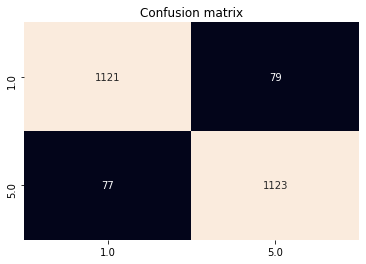

In [72]:
from sklearn.metrics import *
import seaborn as sns
predictions=grid_cntv.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))


labels = grid_cntv.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:

Count_vectorized_model=pd.DataFrame.from_dict(grid_cntv.cv_results_)

In [75]:
print(grid_cntv.best_estimator_)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                          

#### –ì—Ä–∏–¥ –Ω–∞ –≤—ã–±—Ä–∞–ª –∫–∞–∫ –ª—É—á—à–∏–π —É–Ω–∏–≥—Ä–∞–º–º—ã –ø–æ —Å–ª–æ–≤–∞–º

In [76]:
Count_vectorized_model[['param_clf__C','param_clf__penalty','param_vect__analyzer','param_vect__max_df','param_vect__ngram_range','mean_test_accuracy','mean_test_f1']].sort_values('mean_test_accuracy', ascending=False).head(15)

param_clf__C param_clf__penalty param_vect__analyzer param_vect__max_df  \
90           0.1                 l2                 word               0.50   
96           0.1                 l2                 word               1.00   
93           0.1                 l2                 word               0.75   
129          1.0                 l2                 word               0.75   
132          1.0                 l2                 word               1.00   
126          1.0                 l2                 word               0.50   
162         10.0                 l2                 word               0.50   
165         10.0                 l2                 word               0.75   
168         10.0                 l2                 word               1.00   
201        100.0                 l2                 word               0.75   
198        100.0                 l2                 word               0.50   
204        100.0                 l2                 word               1.00   
240       1000.0                 l2                 word               1.00   
237       1000.0                 l2                 word               0.75   
234       1000.0                 l2                 word               0.50   

    param_vect__ngram_range  mean_test_accuracy  mean_test_f1  
90                   (1, 1)            0.932144      0.932185  
96                   (1, 1)            0.931609      0.931723  
93                   (1, 1)            0.931430      0.931472  
129                  (1, 1)            0.930537      0.930626  
132                  (1, 1)            0.930180      0.930213  
126                  (1, 1)            0.929823      0.929909  
162                  (1, 1)            0.928929      0.928988  
165                  (1, 1)            0.928394      0.928442  
168                  (1, 1)            0.928037      0.928002  
201                  (1, 1)            0.927143      0.927100  
198                  (1, 1)            0.926786      0.926692  
204                  (1, 1)            0.926429      0.926298  
240                  (1, 1)            0.925536      0.925395  
237                  (1, 1)            0.925179      0.924991  
234                  (1, 1)            0.924822      0.924662

### –°—Ä–∞–≤–Ω–∏—Ç–µ, –∫–∞–∫ –∏–∑–º–µ–Ω—è–µ—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –ø—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ —Å–∫—Ä—ã—Ç—ã—Ö —Ç–µ–º –≤ –∫–∞—á–µ—Å—Ç–≤–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
      1-—ã–π –≤–∞—Ä–∏–∞–Ω—Ç:  ùë°ùëì‚àíùëñùëëùëì  –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ (sklearn.feature_extraction.text.TfidfTransformer) –∏ —Å–∏–Ω–≥—É–ª—è—Ä–Ω–æ–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–µ (–æ–Ω–æ –∂–µ ‚Äì –ª–∞—Ç–µ–Ω—Ç—ã–π —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑) (sklearn.decomposition.TruncatedSVD),
      2-–æ–π –≤–∞—Ä–∏–∞–Ω—Ç: —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –º–æ–¥–µ–ª–∏ LDA (sklearn.decomposition.LatentDirichletAllocation).

#### 1-—ã–π –≤–∞—Ä–∏–∞–Ω—Ç:  ùë°ùëì‚àíùëñùëëùëì  –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ (sklearn.feature_extraction.text.TfidfTransformer) –∏ —Å–∏–Ω–≥—É–ª—è—Ä–Ω–æ–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–µ (–æ–Ω–æ –∂–µ ‚Äì –ª–∞—Ç–µ–Ω—Ç—ã–π —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑) (sklearn.decomposition.TruncatedSVD),

–ü–æ–ø—Ä–æ–±—É–µ–º —Ç–æ–ª—å–∫–æ ùë°ùëì‚àíùëñùëëùëì  

In [77]:
clf_tf_idf = Pipeline([        
   ('vect', CountVectorizer()), 
       ('tfidf', TfidfTransformer()),   
   ('clf', LogisticRegression()),
])

In [78]:
params_tf_idf={
    
    'vect__analyzer':  ['word','char'],
    
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"] 
}
scores=[ 'accuracy','f1']
grid_tf_idf = GridSearchCV(clf_tf_idf, param_grid=params_tf_idf, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf.fit(X_train, y_train)
print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3024 out of 3024 | elapsed: 20.7min finished


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.75,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=10.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,


In [79]:
grid_tf_idf.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

–ù–µ–º–Ω–æ–≥–æ —É–ª—É—á—à–∏–ª–∏—Å—å —Ä–µ—É–∑–ª—å—Ç–∞—Ç—ã

Precision:   0.95
Recall:   0.95
F1-measure:   0.95
Accuracy:   0.95
              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95      1200
         5.0       0.95      0.94      0.95      1200

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



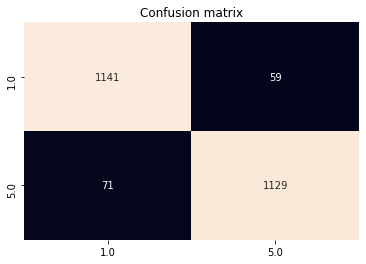

In [80]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = grid_tf_idf.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

–ü–æ–ø—Ä–æ–±—É–µ–º –¥–æ–±–∞–≤–∏—Ç—å —Å–∏–≥–Ω—É–ª—è—Ä–Ω–æ–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–µ

In [84]:
 clf_tf_idf_TruncatedSVD = Pipeline([    
   ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),   
    ('tsvd', TruncatedSVD()),   
   ('clf', LogisticRegression()),
])

In [85]:
params_tf_idf_TruncatedSVD={
    
    'vect__analyzer':  ['word'],
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'tsvd__n_components' : [5,10,25,50,100],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]
}

scores=[ 'accuracy','f1']
grid_tf_idf_TruncatedSVD = GridSearchCV(clf_tf_idf_TruncatedSVD, param_grid=params_tf_idf_TruncatedSVD, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)
print(grid_tf_idf_TruncatedSVD.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 19.8min finished


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 TruncatedSVD(algorithm='randomized', n_components=100,
                              n_iter=5, random_state=None, tol=0.0)),
                ('clf',
                 LogisticRegression(C=100.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                 

Precision:   0.93
Recall:   0.93
F1-measure:   0.93
Accuracy:   0.93
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.93      1200
         5.0       0.93      0.92      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400



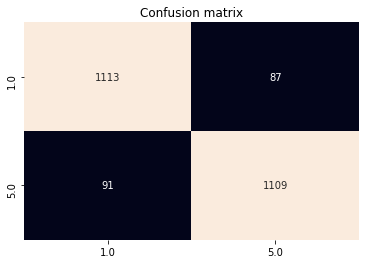

In [86]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

#### 2-–æ–π –≤–∞—Ä–∏–∞–Ω—Ç: —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –º–æ–¥–µ–ª–∏ LDA (sklearn.decomposition.LatentDirichletAllocation).

In [87]:
clf_tf_idf_LDA = Pipeline([
   ('vect', CountVectorizer()),   
    ('lda', LatentDirichletAllocation()),   
   ('clf', LogisticRegression()),
])

In [88]:
params_tf_idf_LDA={    
    'vect__analyzer':  ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'lda__n_components' : [25,50,100],
     "clf__C": np.logspace(-3,3,7),
     "clf__penalty":["l1","l2"]
}

scores=[ 'accuracy','f1']
grid_tf_idf_LDA = GridSearchCV(clf_tf_idf_LDA, param_grid=params_tf_idf_LDA, cv=3,
                         scoring=scores,refit=scores[0],
                         n_jobs=-1, verbose=1)
grid_tf_idf_LDA.fit(X_train, y_train)
print(grid_tf_idf_LDA.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed: 48.7min finished


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.75,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=No...
                                           perp_tol=0.1, random_state=None,
                                           topic_word_prior=None,
                                           total_samples=1000000.0,
                                           verbose=0)),
                ('clf',
                 LogisticRegression(C=1000.0, 

LDA —Å–∏–ª—å–Ω–æ —É—Ö—É–¥—à–∏–ª —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã

Precision:   0.89
Recall:   0.89
F1-measure:   0.89
Accuracy:   0.89
              precision    recall  f1-score   support

         1.0       0.89      0.90      0.89      1200
         5.0       0.90      0.89      0.89      1200

    accuracy                           0.89      2400
   macro avg       0.89      0.89      0.89      2400
weighted avg       0.89      0.89      0.89      2400



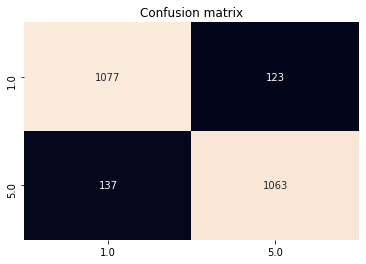

In [89]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = grid_tf_idf_LDA.best_estimator_.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

–ò—Ç–æ–≥–æ:

In [90]:
models=['grid_cntv', 'grid_tf_idf' ,'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']
for model in models:

    print('model: ',model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("F1-measure: {0:6.3f}".format(f1_score(y_test, predictions, average='macro')),';',"Accuracy: {0:6.3f}".format(accuracy_score(y_test, predictions)))

model:  cntv
F1-measure:  0.935 ; Accuracy:  0.935
model:  tf_idf
F1-measure:  0.946 ; Accuracy:  0.946
model:  tf_idf_TruncatedSVD
F1-measure:  0.926 ; Accuracy:  0.926
model:  tf_idf_LDA
F1-measure:  0.892 ; Accuracy:  0.892


#### TF-IDF –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç